# Prepare Dissociated AnnData object

## Load environment

In [1]:
data_dir = "/home/dbdimitrov/Repos/liana2_manuscript/data/kidney_injury/"

In [2]:
import numpy as np
import pandas as pd

import scanpy as sc

In [3]:
import mofax as mofa
import muon as mu
import decoupler as dc

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import liana as li
import plotnine as p9

In [5]:
li.__version__

'0.1.9'

In [6]:
# columns of interest
sample_key = "ident"
groupby = "cell_type"
condition_key = "Group"

### Load Data & Process annotations

In [7]:
adata = sc.read_h5ad(data_dir + "GSE139107_MouseIRI.h5ad")
adata.obs.rename(columns={'celltype': 'cell_state'}, inplace=True)
adata

AnnData object with n_obs × n_vars = 126578 × 27133
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Group', 'Replicates', 'cell_state', 'ident'
    uns: 'X_name'

In [8]:
annot = pd.read_csv(data_dir + "cell_annotations.csv", index_col=None)

In [9]:
adata.obs = adata.obs.reset_index(names='cell_id').merge(annot, on='cell_state', how='left').set_index('cell_id')
adata.obs.index.name = None

In [10]:
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,Group,Replicates,cell_state,ident,cell_type,full_name
IRI4h1_AAACCTGAGATCTGCT,IRI4h1,1458.0,533,4hours,1,CTAL2,IRI4h1,CTAL,Thick ascending limb of loop of Henle
IRI4h1_AAACCTGAGATTACCC,IRI4h1,2490.0,564,4hours,1,NewPT1,IRI4h1,PT,Proximal tubule
IRI4h1_AAACCTGAGTGTTAGA,IRI4h1,514.0,320,4hours,1,EC1,IRI4h1,EC,Epithelial cells
IRI4h1_AAACCTGCACCAACCG,IRI4h1,1171.0,392,4hours,1,DCT,IRI4h1,DCT,Distal convoluted tubule
IRI4h1_AAACCTGCAGCCTGTG,IRI4h1,1712.0,530,4hours,1,MTAL,IRI4h1,MTAL,medullary thick ascending limb
...,...,...,...,...,...,...,...,...,...
IRIsham3_TTTGTCATCAGGTTCA,IRIsham3,506.0,388,Control,3,EC1,IRIsham3,EC,Epithelial cells
IRIsham3_TTTGTCATCATAACCG,IRIsham3,923.0,536,Control,3,PC2,IRIsham3,PC,Principal cells
IRIsham3_TTTGTCATCCGTCATC,IRIsham3,1865.0,692,Control,3,PTS3,IRIsham3,PT,Proximal tubule
IRIsham3_TTTGTCATCCTTCAAT,IRIsham3,1982.0,660,Control,3,PTS2,IRIsham3,PT,Proximal tubule


## QC

Filter low quality cells & features

In [11]:
adata

AnnData object with n_obs × n_vars = 126578 × 27133
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Group', 'Replicates', 'cell_state', 'ident', 'cell_type', 'full_name'
    uns: 'X_name'

In [12]:
# filter cells and genes
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=5)

Filter Non-expressed cell types

In [13]:
# set filtering parameters
min_cells = 15 # min number of cells per cell type
min_samples = 10 # min number of samples that pass the threshold per cell type

# get cell num per sample per cluster
celltype_qc = adata.obs.groupby([sample_key, groupby]).size().reset_index(name='counts')
# check which rows (sample-cell type combo) pass threshold
celltype_qc['keep_min'] = celltype_qc['counts'] >= min_cells
# how many samples passed the threshold
celltype_qc['keep_sum'] = celltype_qc.groupby(groupby)['keep_min'].transform('sum')
# identify which cell types don't pass sample threshold
celltype_qc['keep_celltype'] = celltype_qc['keep_sum'] >= min_samples
celltype_qc = celltype_qc[[sample_key, groupby, "keep_sum", 'keep_min', 'keep_celltype']]
# drop duplicates
celltype_qc = celltype_qc.drop_duplicates()

In [14]:
celltype_qc.drop_duplicates([groupby, "keep_celltype"])

,ident,cell_state,keep_sum,keep_min,keep_celltype
0,IRI12h1b1,CNT,24,True,True
1,IRI12h1b1,CTAL1,24,True,True
2,IRI12h1b1,CTAL2,24,True,True
3,IRI12h1b1,DCT,24,True,True
4,IRI12h1b1,DCT-CNT,22,True,True
5,IRI12h1b1,DTL-ATL,24,True,True
6,IRI12h1b1,EC1,24,True,True
7,IRI12h1b1,EC2,12,True,True
8,IRI12h1b1,Fib,24,True,True
9,IRI12h1b1,ICA,24,True,True


In [15]:
adata.obs = adata.obs.reset_index().merge(celltype_qc, how='left').set_index('index')
adata.obs.index.name = None

In [16]:
adata = adata[(adata.obs['keep_celltype']), :]

In [17]:
adata.obs[groupby]

IRI4h1_AAACCTGAGATCTGCT       CTAL2
IRI4h1_AAACCTGAGATTACCC      NewPT1
IRI4h1_AAACCTGAGTGTTAGA         EC1
IRI4h1_AAACCTGCACCAACCG         DCT
IRI4h1_AAACCTGCAGCCTGTG        MTAL
                              ...  
IRIsham3_TTTGTCATCAGGTTCA       EC1
IRIsham3_TTTGTCATCATAACCG       PC2
IRIsham3_TTTGTCATCCGTCATC      PTS3
IRIsham3_TTTGTCATCCTTCAAT      PTS2
IRIsham3_TTTGTCATCGTCCGTT      PTS1
Name: cell_state, Length: 126313, dtype: object

### Normalize

In [18]:
adata.layers['counts'] = adata.X.copy()

/tmp/ipykernel_9416/1155977868.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [19]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

## Check Slc34a2

In [23]:
sc.pp.pca(adata)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

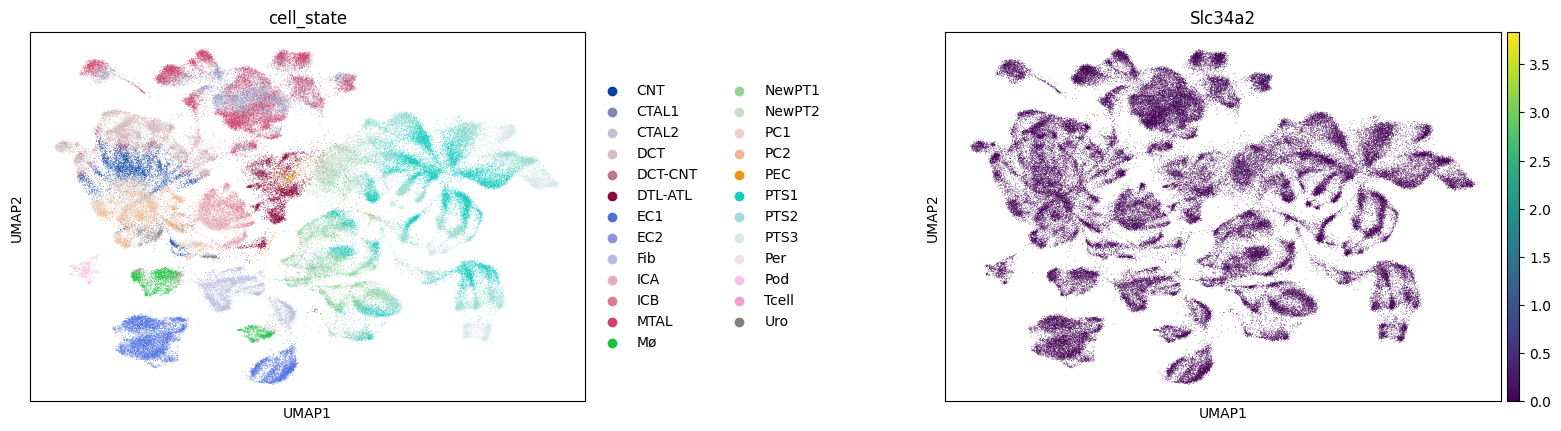

In [25]:
sc.pl.umap(adata, color=[groupby, 'Slc34a2'], wspace=0.5)

In [34]:
from matplotlib.pyplot import hist

<AxesSubplot:xlabel='cell_state'>

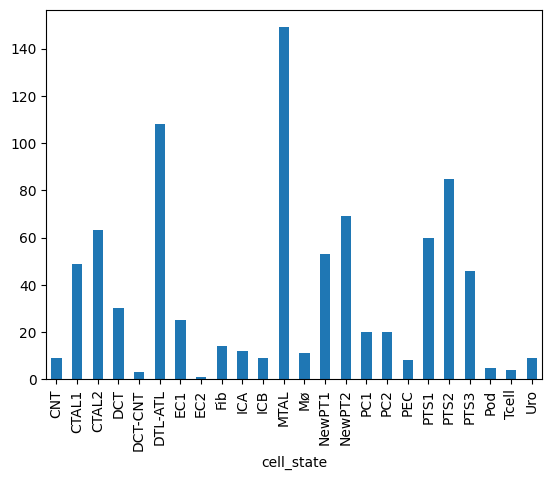

In [46]:
adata[np.array(adata[:,'Slc34a2'].X.A > 0),:].obs.groupby(groupby).size().plot(kind='bar')

Save the AnnData object

In [52]:
adata.write_h5ad(data_dir + "aki_processed.h5ad")

In [53]:
adata

AnnData object with n_obs × n_vars = 126048 × 24629
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Group', 'Replicates', 'cell_state', 'ident', 'cell_type', 'full_name', 'keep_sum', 'keep_min', 'keep_celltype', 'n_genes'
    var: 'n_cells'
    uns: 'X_name', 'log1p'
    layers: 'counts'